# import, data read

In [2]:
import pandas as pd, numpy as np
import scipy
import matplotlib.pyplot as plt
from scipy.linalg import sqrtm

In [3]:
df = pd.read_csv('market_data_binance.by_minute_ALL_2022-09-19T04:00:00Z_2022-09-20T03:59:00Z.csv')
df['time'] = pd.to_datetime(df['timestamp'],unit='s')
df_close = df.pivot(index='time', columns='symbol', values='close').resample('10min').last()

In [18]:
#symbols = ['YFIIUSDT', 'ETHUSDT', 'PAXGUSDT']
symbols = ['YFIIUSDT', 'ETHUSDT', 'PAXGUSDT', 'BIFIUSDT', 'BNBUSDT']
df_close_symbols = df_close[symbols]

In [19]:
df_close_symbols

symbol,YFIIUSDT,ETHUSDT,PAXGUSDT,BIFIUSDT,BNBUSDT
time,,,,,
2022-09-19 04:00:00,834.2,1300.92,1659.0,340.1,262.3
2022-09-19 04:10:00,834.6,1303.61,1659.0,340.1,262.3
2022-09-19 04:20:00,835.4,1303.85,1660.0,343.0,261.9
2022-09-19 04:30:00,835.0,1304.09,1659.0,341.3,261.3
2022-09-19 04:40:00,837.4,1305.19,1659.0,341.7,261.3
...,...,...,...,...,...
2022-09-20 03:10:00,879.8,1349.10,1666.0,345.6,268.2
2022-09-20 03:20:00,874.4,1344.29,1666.0,344.5,267.9
2022-09-20 03:30:00,879.8,1349.84,1667.0,344.6,268.6


# portmanteau

In [6]:
def calc_autocov_matrix(arr, lag):
    m = arr.shape[0]  # sample size.
    return 1 / (m - lag - 1) * (arr[lag:] - np.nanmean(arr[lag:], axis=0)).T @ (arr[:m-lag] - np.nanmean(arr[:m-lag], axis=0))

In [56]:
def get_pmt_wgts(df, lags):
    cov = df.cov().values
    cov_inv_sqrt = np.linalg.inv(sqrtm(cov))

    pmt = 0;
    for i in range(1, lags+1):
        autocov = calc_autocov_matrix(df.values, i)
        pmt += np.square(cov_inv_sqrt @ autocov @ cov_inv_sqrt)
    pmt /= lags;

    pmt_eigen_vals, pmt_eigen_vecs = np.linalg.eig(pmt)
    asc = np.argsort(pmt_eigen_vals)
    pmt_eigen_vals, pmt_eigen_vecs = pmt_eigen_vals[asc], pmt_eigen_vecs[:, asc]
    wgts = rho_inv_sqrt @ pmt_eigen_vecs
    return pmt_eigen_vals, pmt_eigen_vecs, wgts

# portfolio graphs

In [61]:
pmt_eigen_vals, pmt_eigen_vecs, wgts = get_pmt_wgts(df_close_symbols, 5)

In [62]:
pmt_eigen_vals

array([0.11167139, 0.22393113, 0.38384026, 0.41705341, 0.69561902])

In [63]:
wgts

array([[-3.97165900e-02,  3.02569312e-02,  1.53801521e-01,
        -6.40665907e-02,  6.71238990e-02],
       [-6.54577201e-02, -1.10298462e-01, -2.70316009e-02,
         1.56345373e-01, -9.12582891e-02],
       [ 6.90306402e-02,  6.10718482e-01,  1.33190690e-02,
        -7.92145454e-02,  2.54547905e-02],
       [ 7.99057123e-01,  1.94252287e-01,  5.21390579e-04,
        -5.63049592e-02,  5.12810104e-02],
       [-1.95514598e-01, -1.96659826e-01, -4.51798387e-01,
        -7.54708348e-01,  6.71656158e-02]])

<Axes: xlabel='time'>

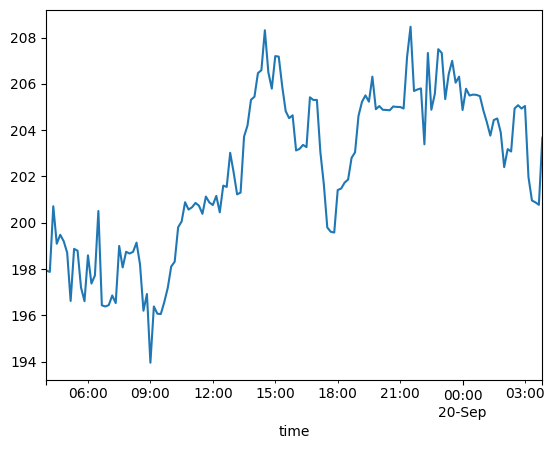

In [53]:
((df_close_symbols) * pmt_eigen_vecs[:,0]).sum(axis=1).plot()

<Axes: xlabel='time'>

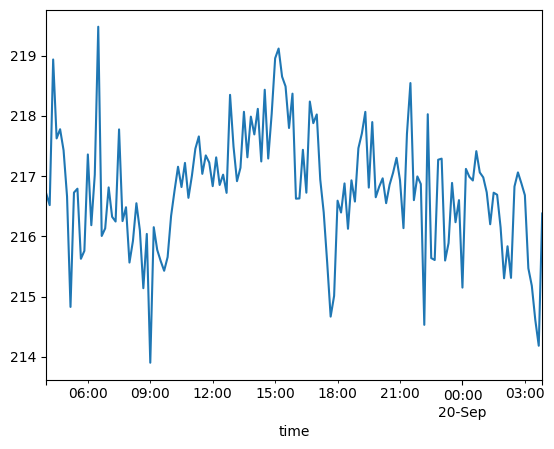

In [54]:
((df_close_symbols) * wgts[:,0]).sum(axis=1).plot()

<Axes: xlabel='time'>

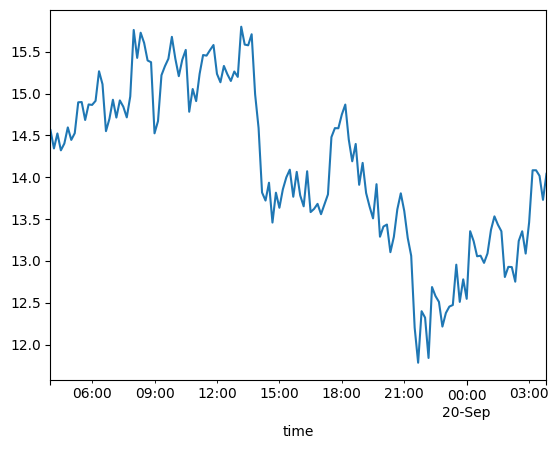

In [55]:
((df_close_symbols) * wgts[:,-1]).sum(axis=1).plot()